<a href="https://colab.research.google.com/github/dan22333/NLP/blob/master/L12_tutorial_cheese_classification_model_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<a href="https://colab.research.google.com/drive/1GIslUzm62UsiDCWleLdANaNM-Z7JiExB?usp=sharing" target="_blank" >
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>

<hr style="height:2pt">


<h1 style="padding-top: 25px;padding-bottom: 25px;text-align: left; padding-left: 10px; background-color: #DDDDDD;
    color: black;"> <img style="float: left; padding-right: 10px;" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png" height="50px"> <a href='https://harvard-iacs.github.io/2024-AC215/' target='_blank'><strong><font color="#A41034">AC215: Productionizing AI (MLOps)</font></strong></a></h1>

# **<font color="#A41034">Tutorial -  Cheese Classification Models, Experimental Tracking</font>**

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructor:** Pavlos Protopapas<br/>
**Authors:** Shivas Jayaram

<hr style="height:2pt">

## **<font color="#A41034">Setup Notebook</font>**

**Copy & setup Colab with GPU**

1) Select "File" menu and pick "Save a copy in Drive"  
2) This notebooks is already setup to use GPU but if you want to change it. Go to "Runtime" menu and select "Change runtime type". Then in the popup in "Hardware accelerator" select "GPU" and then click "Save"   
3) If you want high RAM there is an option for that

In [ ]:
#!pip install tensorflow==2.13.1

**Imports**

In [ ]:
import os
import requests
import zipfile
import tarfile
import shutil
import math
import json
import time
import sys
import cv2
import string
import re
import subprocess
import hashlib
import numpy as np
import pandas as pd
from glob import glob
import collections
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Tensorflow Hub
import tensorflow_hub as hub

# Colab auth
from google.colab import auth
from google.cloud import storage

**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

tensorflow version 2.17.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Run this cell to see what GPU you have. If you get a P100 or T4 GPU that's great. If it's K80, it will still work but it will be slow.

In [ ]:
!nvidia-smi

Sat Nov  9 15:53:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              28W /  70W |    105MiB / 15360MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Utils**

Here are some util functions that we will be using for this notebook

In [ ]:
def download_file(packet_url, base_path="", extract=False, headers=None):
  if base_path != "":
    if not os.path.exists(base_path):
      os.mkdir(base_path)
  packet_file = os.path.basename(packet_url)
  with requests.get(packet_url, stream=True, headers=headers) as r:
      r.raise_for_status()
      with open(os.path.join(base_path,packet_file), 'wb') as f:
          for chunk in r.iter_content(chunk_size=8192):
              f.write(chunk)

  if extract:
    if packet_file.endswith(".zip"):
      with zipfile.ZipFile(os.path.join(base_path,packet_file)) as zfile:
        zfile.extractall(base_path)
    else:
      packet_name = packet_file.split('.')[0]
      with tarfile.open(os.path.join(base_path,packet_file)) as tfile:
        tfile.extractall(base_path)

def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0],
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })

  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  # Save the enitire model (structure + weights)
  #print(experiment_name, model_name)
  model.save(os.path.join(experiment_name,model_name+".keras"))

  # Save only the weights
  model.save_weights(os.path.join(experiment_name,model_name+".weights.h5"))

  # Save the structure only
  model_json = model.to_json()
  with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
      json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".weights.h5")).st_size
  return model_size

def evaluate_save_model(model,test_data, model_train_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):

  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()

  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)

  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## **<font color="#A41034">Dataset</font>**

#### **Download**

In [ ]:
start_time = time.time()
download_file("https://github.com/dlops-io/datasets/releases/download/v4.0/cheese_4_labels.zip", base_path="datasets", extract=True)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

Download execution time (mins) 1.2461567799250284


### **Load Data**

* Read-in data as lists.
* Each element in data_x is the path to the image
* Each element in data_y is the label of that image

In [ ]:
base_path = os.path.join("datasets","cheese")
label_names = os.listdir(base_path)
print("Labels:", label_names)

# Number of unique labels
num_classes = len(label_names)
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

# Generate a list of labels and path to images
data_list = []
for label in label_names:
  # Images
  image_files = os.listdir(os.path.join(base_path,label))
  data_list.extend([(label,os.path.join(base_path,label,f)) for f in image_files])

print("Full size of the dataset:",len(data_list))
print("data_list:",data_list[:5])

Labels: ['gruyere', 'brie', 'parmigiano', 'gouda']
Full size of the dataset: 1156
data_list: [('gruyere', 'datasets/cheese/gruyere/Image_268.png'), ('gruyere', 'datasets/cheese/gruyere/Image_60.jpg'), ('gruyere', 'datasets/cheese/gruyere/Image_124.jpeg'), ('gruyere', 'datasets/cheese/gruyere/Image_263.jpg'), ('gruyere', 'datasets/cheese/gruyere/Image_247.jpg')]


### **View Images**

Let's take a look at the data.

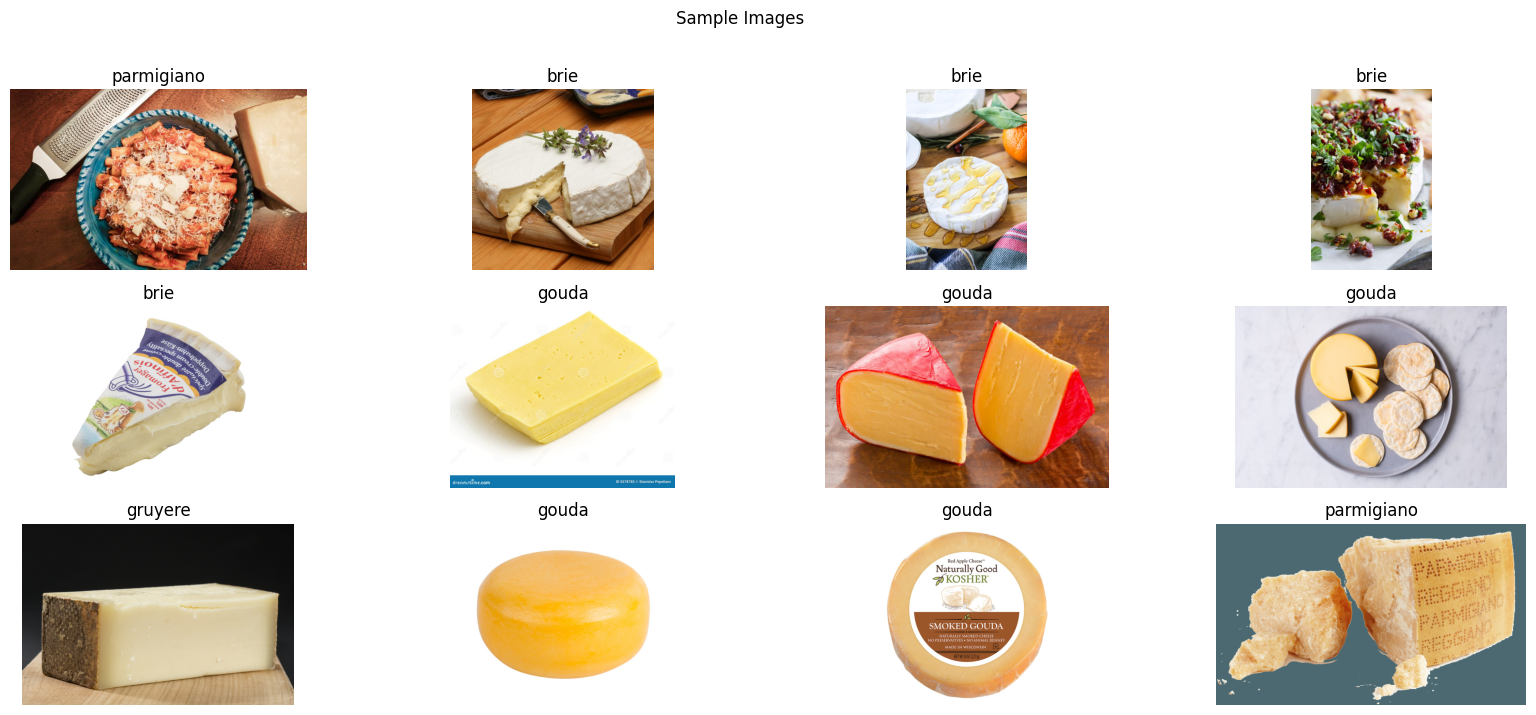

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(data_list)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(data_list[img_idx][0])
    # Read image
    image = cv2.imread(data_list[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

### **Dataset Metrics**

In [ ]:
# Compute dataset metrics
compute_dataset_metrics(data_list)

Dataset Metrics:
----------------
Label Counts:
label
parmigiano    291
brie          289
gruyere       288
gouda         288
Name: count, dtype: int64
Image Width:
Min: 160.0  Max: 7200.0
Image Height:
Min: 170.0  Max: 6000.0
Size in memory: 6679.46 MB


## **<font color="#A41034">Build Data Pipelines</font>**

### **Load X & Y**

Generate data_x and data_y

In [ ]:
# Build data x, y
data_x = [itm[1] for itm in data_list]
data_y = [itm[0] for itm in data_list]

print("data_x:",len(data_x))
print("data_y:",len(data_y))
print("data_x:",data_x[:5])
print("data_y:",data_y[:5])

data_x: 1156
data_y: 1156
data_x: ['datasets/cheese/gruyere/Image_268.png', 'datasets/cheese/gruyere/Image_60.jpg', 'datasets/cheese/gruyere/Image_124.jpeg', 'datasets/cheese/gruyere/Image_263.jpg', 'datasets/cheese/gruyere/Image_247.jpg']
data_y: ['gruyere', 'gruyere', 'gruyere', 'gruyere', 'gruyere']


### **Split Data**
We split data into test, validation, & train

In [ ]:
test_percent = 0.10
validation_percent = 0.2

# Split data into train / test
train_validate_x, test_x, train_validate_y, test_y = train_test_split(data_x, data_y, test_size=test_percent)

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(train_validate_x, train_validate_y, test_size=test_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))
print("test_x count:",len(test_x))

train_x count: 936
validate_x count: 104
test_x count: 116


### **Create TF Datasets**

In [ ]:
def get_dataset(image_width = 224, image_height = 224, num_channels = 3, batch_size = 32):

  # Load Image
  def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=num_channels)
    image = tf.image.resize(image, [image_height,image_width])
    return image, label

  # Normalize pixels
  def normalize(image, label):
    image = image/255
    return image, label

  train_shuffle_buffer_size= len(train_x)
  validation_shuffle_buffer_size= len(validate_x)

  # Convert all y labels to numbers
  train_processed_y = [label2index[label] for label in train_y]
  validate_processed_y = [label2index[label] for label in validate_y]
  test_processed_y = [label2index[label] for label in test_y]

  # Converts to y to binary class matrix (One-hot-encoded)
  train_processed_y = to_categorical(train_processed_y, num_classes=num_classes)#, dtype='float32')
  validate_processed_y = to_categorical(validate_processed_y, num_classes=num_classes)#, dtype='float32')
  test_processed_y = to_categorical(test_processed_y, num_classes=num_classes)#, dtype='float32')

  # Create TF Dataset
  train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
  validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))
  test_data = tf.data.Dataset.from_tensor_slices((test_x, test_processed_y))

  #############
  # Train data
  #############
  # Apply all data processing logic
  train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
  train_data = train_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  train_data = train_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
  train_data = train_data.batch(batch_size)
  train_data = train_data.prefetch(tf.data.AUTOTUNE)

  ##################
  # Validation data
  ##################
  # Apply all data processing logic
  validation_data = validation_data.shuffle(buffer_size=validation_shuffle_buffer_size)
  validation_data = validation_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  validation_data = validation_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
  validation_data = validation_data.batch(batch_size)
  validation_data = validation_data.prefetch(tf.data.AUTOTUNE)

  ############
  # Test data
  ############
  # Apply all data processing logic
  test_data = test_data.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
  test_data = test_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
  test_data = test_data.batch(batch_size)
  test_data = test_data.prefetch(tf.data.AUTOTUNE)

  return (
      train_data, validation_data, test_data
  )

## **<font color="#A41034">Image Classificaton Models</font>**

### **Create Experiment**

We will use our util functions to create an experiment to keep track of hyper parameters, metrics, models etc.

In [ ]:
# Create an experiment
create_experiment()

### **1) Two Block CNN Network**

In [ ]:
# Build Model
def build_2_block_model(image_height, image_width, num_channels, num_classes, model_name):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name=model_name)

  return model

### **Train**

In [ ]:
############################
# Training Params
############################
model_name = "2_block"
learning_rate = 0.01
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
epochs = 1

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size)

# Model
model = build_2_block_model(image_height, image_width, num_channels, num_classes, model_name)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history


Model: "2_block"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │      25,690,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,950,596 (98.99 MB)

 Trainable params: 25,950,596 (98.99 MB)

 Non-trainable params: 0 (0.00 B)

None
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 890ms/step - accuracy: 0.2506 - loss: 1.3925 - val_accuracy: 0.2788 - val_loss: 1.3806
Training execution time (mins) 0.8090440352757772


In [ ]:
experiment_name

'experiment_1731167726'

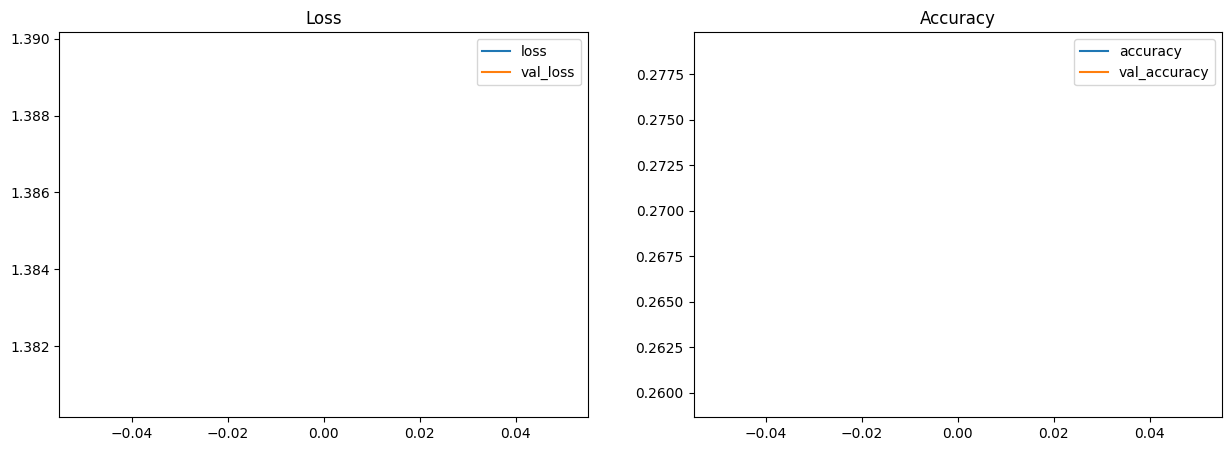

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.2400 - loss: 1.3896
[1.3897712230682373, 0.23275862634181976]


In [ ]:

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **2) Four Block CNN Network**

In [ ]:
# Build Model
def build_4_block_model(image_height, image_width, num_channels, num_classes, model_name):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=64, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name=model_name)

  return model

### **Train**

Model: "4_block"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                           

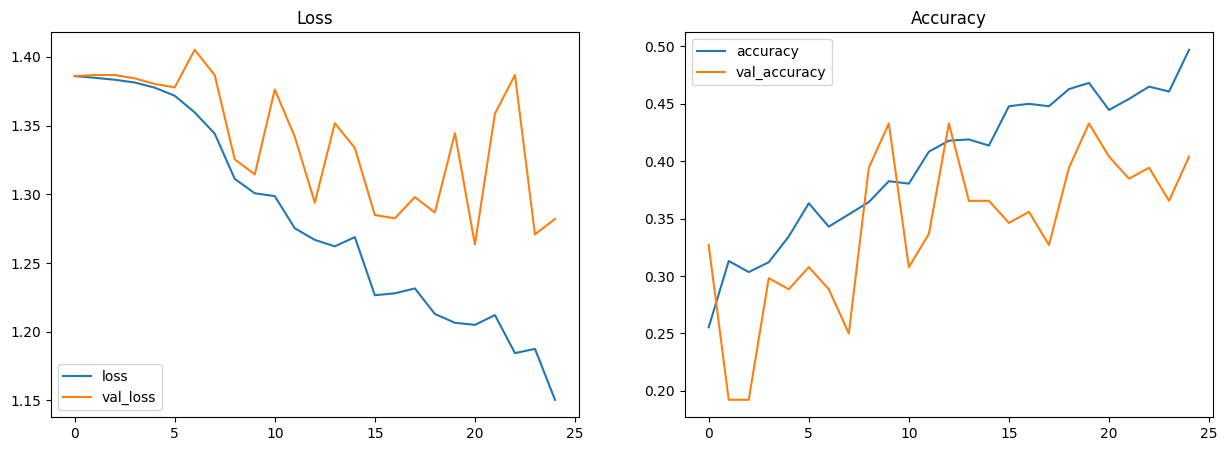

4/4 [==============================] - 9s 2s/step - loss: 1.2261 - accuracy: 0.4052
[1.2261128425598145, 0.4051724076271057]


In [ ]:
############################
# Training Params
############################
model_name = "4_block"
learning_rate = 0.01
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
epochs = 25

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size)

# Model
model = build_4_block_model(image_height, image_width, num_channels, num_classes, model_name)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **3) VGG Style Network**

In [ ]:
# Build Model
def build_vgg_style_model(image_height, image_width, num_channels, num_classes, model_name):
  # Model input
  input_shape = [image_height, image_width, num_channels] # height, width, channels
  model_input = keras.Input(shape=input_shape)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(model_input)
  hidden = keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Hidden Layer, Convolution Block
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu')(hidden)
  hidden = keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(hidden)

  # Flatten
  hidden = keras.layers.Flatten()(hidden)

  #  Hidden Layer, Classification Block
  hidden = keras.layers.Dense(units=512, activation='relu')(hidden)
  hidden = keras.layers.Dense(units=512, activation='relu')(hidden)

  # Output Layer
  output = keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = Model(model_input, output, name=model_name)

  return model

### **Train**

Model: "vgg_style"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                         

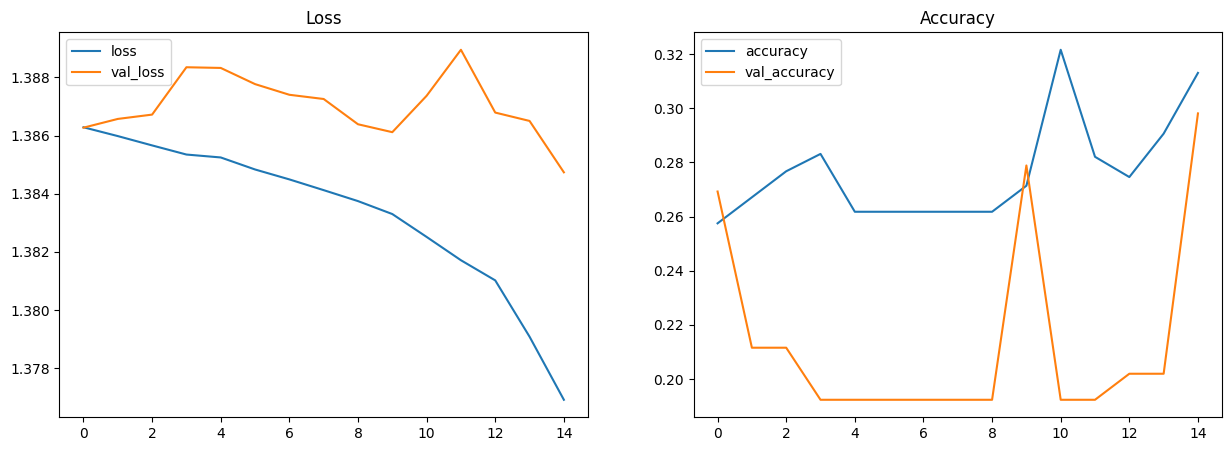

4/4 [==============================] - 10s 2s/step - loss: 1.3844 - accuracy: 0.2759
[1.3844181299209595, 0.27586206793785095]


In [ ]:
############################
# Training Params
############################
model_name = "vgg_style"
learning_rate = 0.01
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
epochs = 15

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size)

# Model
model = build_vgg_style_model(image_height, image_width, num_channels, num_classes, model_name)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **4) MobileNet - Transfer Learning**

In [ ]:
# Build Model
def build_mobilenet_model(image_height, image_width, num_channels, num_classes,model_name, train_base = False):

  # Load the base model with imagenet weights without top layer
  base_model = tf.keras.applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=(image_height, image_width, num_channels))
  base_model.trainable = train_base
  #base_model.summary(show_trainable=True, expand_nested=True)

  # Model input
  input = tf.keras.Input(shape=(image_height, image_width, num_channels), name="input")
  # Add new layers on top of the model
  x = base_model(input, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)
  # x = tf.keras.layers.Dropout(DROPOUT)(x) # optional for your own experiments
  x = tf.keras.layers.Dense(units=128, activation='relu')(x)
  predictions = tf.keras.layers.Dense(units=num_classes, activation='softmax', name="output")(x)
  model = tf.keras.models.Model(inputs=input, outputs=predictions, name=model_name+'_'+str(train_base))

  return model

### **Train - Feature Extraction**

Freeze the base

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 22s 436ms/step - accuracy: 0.2678 - loss: 1.5346 - val_accuracy: 0.3173 - val_loss: 1.3949
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.3381 - loss: 1.3418 - val_accuracy: 0.3654 - val_loss: 1.3382
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.4075 - loss: 1.2903 - val_accuracy: 0.3654 - val_loss: 1.2943
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step - accuracy: 0.4507 - loss: 1.2438 - val_accuracy: 0.4038 - val_loss: 1.2498
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.5014 - loss: 1.1936 - val_accuracy: 0.4327 - val_loss: 1.2120
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 191ms/step - accuracy: 0.5504 - loss: 1.1225 - val_accuracy: 0.4615 - val_loss: 1.1799
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 190ms/step - accuracy: 0.5640 - loss: 1.1045 - val_accuracy: 0.4712 - val_loss: 1.1449
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 208ms/step - 

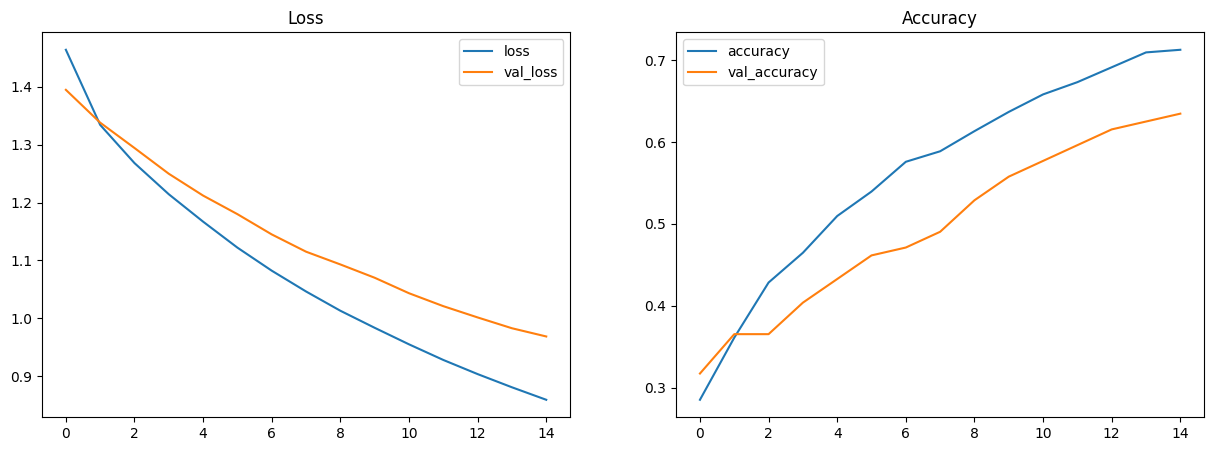

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.6984 - loss: 0.9304
[0.8993721008300781, 0.7068965435028076]


In [ ]:
############################
# Training Params
############################
model_name = "mobilenetv2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
epochs = 15

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size)

# Model
model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, model_name, train_base = False)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
#print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

### **Train - Fine-Tuning**

Unfreeze the base

In [ ]:
############################
# Training Params
############################
model_name = "mobilenetv2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 32
epochs = 15

# Free up memory
K.clear_session()

# Data
train_data, validation_data, test_data = get_dataset(image_width = image_width,
                                                     image_height = image_height,
                                                     num_channels = num_channels,
                                                     batch_size = batch_size)

# Model
model = build_mobilenet_model(image_height, image_width, num_channels, num_classes, model_name, train_base = True)
# Optimizer
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
# Loss
loss = keras.losses.categorical_crossentropy
# Print the model architecture
##print(model.summary())
# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs,
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Get model training history
training_history = training_results.history

# Save and custom model tracking
evaluate_save_model(model,test_data, training_history,execution_time, learning_rate, batch_size, epochs, optimizer,save=True)

Epoch 1/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 49s 824ms/step - accuracy: 0.2271 - loss: 1.5458 - val_accuracy: 0.2885 - val_loss: 1.4545
Epoch 2/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step - accuracy: 0.4302 - loss: 1.2534 - val_accuracy: 0.3077 - val_loss: 1.3309
Epoch 3/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.6047 - loss: 1.0847 - val_accuracy: 0.3750 - val_loss: 1.2612
Epoch 4/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 203ms/step - accuracy: 0.7060 - loss: 0.9584 - val_accuracy: 0.4519 - val_loss: 1.1781
Epoch 5/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - accuracy: 0.7839 - loss: 0.8132 - val_accuracy: 0.4712 - val_loss: 1.1115
Epoch 6/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - accuracy: 0.8198 - loss: 0.7543 - val_accuracy: 0.5577 - val_loss: 1.0405
Epoch 7/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 199ms/step - accuracy: 0.8167 - loss: 0.6923 - val_accuracy: 0.5769 - val_loss: 0.9980
Epoch 8/15
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - accuracy: 0.8653 - loss: 0.5947 - val_accuracy: 0

## **<font color="#A41034">Experiment Results</font>**

#### **Compare Models**

In [ ]:
models_metrics_list = glob(experiment_name+"/*_model_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    model_metrics["name"] = mm_file.replace(experiment_name+"/","").replace("_model_metrics.json","")
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

#### **Find Best Model**

In [ ]:
best_model = experiment_name+'/'+view_metrics.iloc[0]["name"]+".keras"
print(best_model)

### **Predict using the best model**

In [ ]:
# Load a model from disk
prediction_model = tf.keras.models.load_model(best_model)
prediction_model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
predictions.shape: (12, 4)
[0.02324944 0.0103647  0.8350631  0.13132277] 2


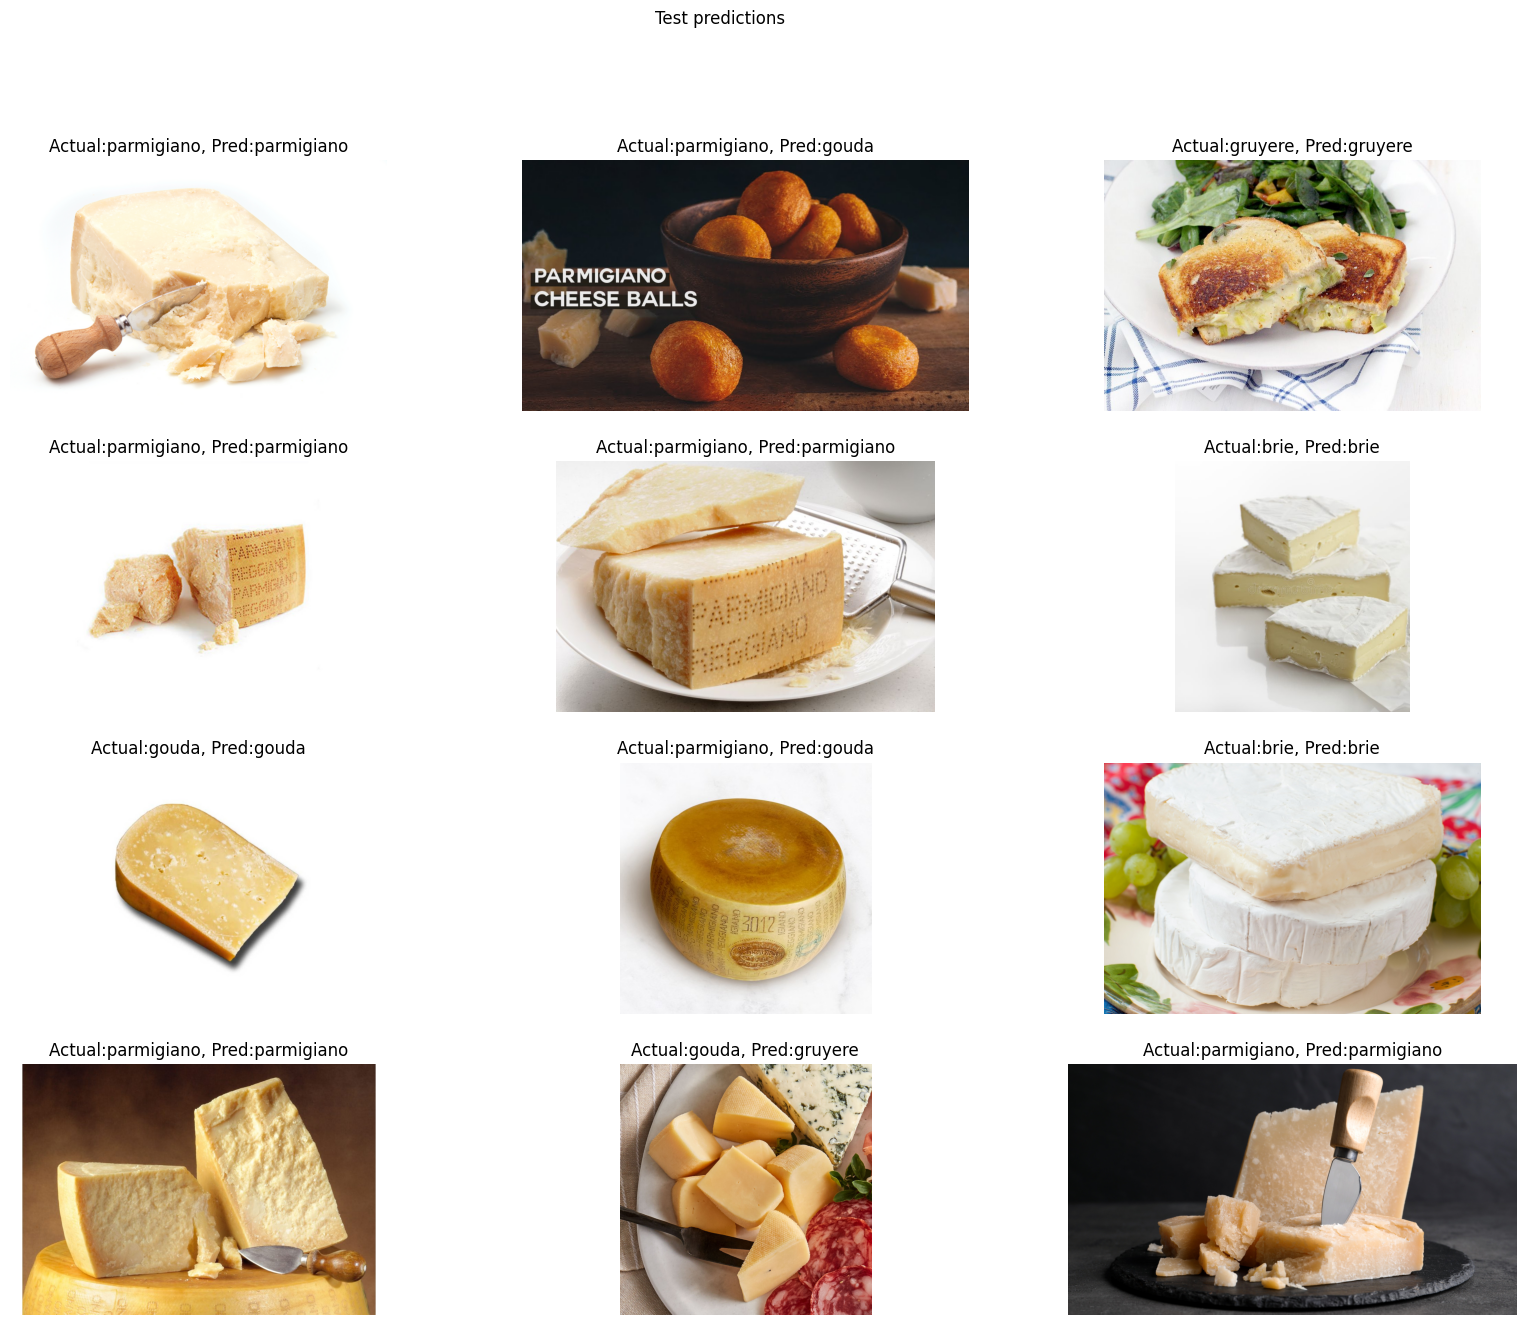

In [ ]:
# Generate a random sample of index
image_samples = np.random.randint(0,high=len(test_x)-1, size=12)
image_width = 224
image_height = 224
num_channels = 3

# Prepare the data
def preprocess_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=num_channels)
  image = tf.image.resize(image, [image_height, image_width])

  image = keras.applications.mobilenet.preprocess_input(image)

  return image

prediction_image_paths = [test_x[img_idx] for img_idx in image_samples]
# Prepare the data for prediction
prediction_data = tf.data.Dataset.from_tensor_slices((prediction_image_paths))
prediction_data = prediction_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
prediction_data = prediction_data.batch(len(prediction_image_paths))

# Make prediction
predictions = prediction_model.predict(prediction_data)
print("predictions.shape:",predictions.shape)
print(predictions[0],predictions[0].argmax())

fig = plt.figure(figsize=(20,15))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(4,3,i+1)

    # Read image
    image = cv2.imread(test_x[img_idx])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)

    # Actual label vs prediction
    prediction_label = index2label[predictions[i].argmax()]
    axs.set_title("Actual:"+test_y[img_idx]+", Pred:"+prediction_label)


    plt.axis('off')

plt.suptitle("Test predictions")
plt.show()

## **<font color="#A41034">Upload Experiment to Cloud Storage</font>**

### **Login using Google Acccount**

In [ ]:
# Authenticate
auth.authenticate_user()

In [ ]:
# REPLACE
GCP_PROJECT = "ac215-project" # [REPLACE WITH YOUR GCP PROJECT]
GCS_BUCKET_NAME = "cheese-app-models" # [REPLACE WITH YOUR GCP PROJECT]

### **Save Experiment**

In [ ]:
# Save data details used for the experiment
data_details = {
  "image_width": image_width,
  "image_height": image_height,
  "num_channels": num_channels,
  "num_classes": num_classes,
  "label2index": label2index,
  "index2label": index2label
}
# Save data details used for the experiment
save_data_details(data_details)
print("Uploadin Experiment:",experiment_name)

# Upload experiment to GCS bucket
storage_client = storage.Client(project = GCP_PROJECT)
# Get bucket for Experiments
bucket = storage_client.get_bucket(GCS_BUCKET_NAME)
print("Model Bucket:",bucket)

# Copy the experiment folder to GCP Bucket
for file_path in glob(experiment_name+'/*'):
  print(file_path)
  blob = bucket.blob(file_path)
  print('uploading file', file_path)
  blob.upload_from_filename(file_path)
